In [1]:
import sys
import torch
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.optimization import AdamW
from tqdm import tqdm
from attack_utils import *
from dataset_utils import *
from Attack import *
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
mod_size = "70m"
model_title = f"pythia-{mod_size}-deduped"
model_name = "EleutherAI/" + model_title
model_revision = "step143000"
model_cache_dir = "./"+ model_title +"/"+model_revision

In [3]:
training_dataset = load_train_pile_random(number=5000,seed=229,num_splits=1)[0]
validation_dataset = load_val_pile(number=5000, seed=229, num_splits=1)[0]

Warning! Shadow models requires an even number of splits! You specified 1 splits.


Found cached dataset parquet (/home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ea5dcc659448d52f.arrow
Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pile-deduped-pythia-random-sampled-ef6db9ddd170a4bc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-309796835bdc8901.arrow
No config specified, defaulting to: the_pile_val/all
Found cached dataset the_pile_val (/home/ec2-user/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30)


Warning! If using shadow models, use an even number of splits! You specified 1 splits.


Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30/cache-0289bfade3adba36.arrow


In [4]:
model = GPTNeoXForCausalLM.from_pretrained(model_name,revision=model_revision,cache_dir=model_cache_dir)
max_length = model.config.max_position_embeddings
del model
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")

  0%|          | 0/5000 [00:00<?, ?it/s]/home/ec2-user/unlearning-large/dataset_utils.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
100%|██████████| 5000/5000 [02:00<00:00, 41.65it/s]
/home/ec2-user/unlearning-large/attack_utils.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/home/ec2-user/unlearning-large/attack_utils.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statis

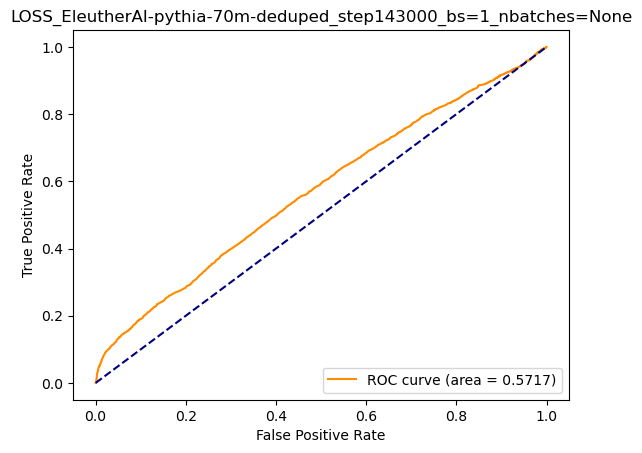

/home/ec2-user/unlearning-large/attack_utils.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_statistic = torch.tensor(train_statistic).flatten()
/home/ec2-user/unlearning-large/attack_utils.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_statistic = torch.tensor(val_statistic).flatten()


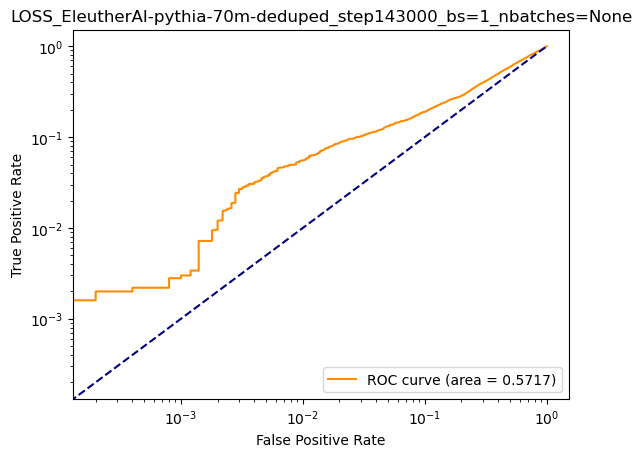

In [5]:
training_dataloader = DataLoader(training_dataset, batch_size = 1, collate_fn=lambda batch: collate_fn(batch, tokenizer=tokenizer, length=max_length))
validation_dataloader = DataLoader(validation_dataset, batch_size = 1, collate_fn=lambda batch: collate_fn(batch, tokenizer=tokenizer, length=max_length))

LOSSer = LOSS(model_name, model_revision=model_revision, cache_dir=model_cache_dir)
config = {
    "training_dl": training_dataloader,
    "validation_dl": validation_dataloader,
    "bs" : 1,
    "nbatches": None,
    "samplelength": None,
    "device": device
}

LOSSer.inference(config)

LOSSer.attack_plot_ROC(log_scale = False)
LOSSer.attack_plot_ROC(log_scale = True)

In [ ]:
config_mope = {
    "training_dl": training_dataloader,
    "validation_dl": validation_dataloader,
    "n_new_models": 20,
    "noise_variance": 0.05,
    "bs" : bs,
    "nbatches": 250,
    "samplelength": 50,
    "device": device
}

MoPer = MoPe(model_name, model_revision=model_revision, cache_dir=model_cache_dir)
MoPer.inference(config_mope)

MoPer.attack_plot_ROC( "LOSS_70m_mope", show_plot = True, save_name = "LOSS_70m_mope", log_scale = False)

In [ ]:
loss_train, loss_valid = LOSSer.get_statistics()
mope_train, mope_valid = MoPer.get_statistics()

# Create the scatter plot
plt.scatter(loss_train, mope_train, c='orange', label='Training')
plt.scatter(loss_test, mope_test, c='blue', label='Validation')

# Set labels and title
plt.xlabel('LOSS')
plt.ylabel('MoPe')
plt.title('LOSS vs. MoPe')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
trainlabels = []
validlabels = []
for batchno, data_x in tqdm(enumerate(training_dataloader),total=len(training_dataloader)):
  if batchno > 2000:
    break
  trainlabels += [tokenizer.decode(seq[:10]) for seq in data_x["input_ids"]]


for batchno, data_x in tqdm(enumerate(validation_dataloader),total=len(validation_dataloader)):
  if batchno > 2000:
    break
  validlabels += [tokenizer.decode(seq[:10]) for seq in data_x["input_ids"]]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
scattertrain = ax.scatter(loss_train, mope_train, c='orange', label='Training')
scattervalid = plt.scatter(loss_valid, mope_valid, c='blue', label='Validation')


train_ind = [403,721, 619, 711, 311, 237, 833, 181 , 91, 846, 512, 399, 977, 276, 840]

# Add labels to the training points
for ind in train_ind:
    ax.text(loss_train[ind], mope_train[ind], trainlabels[ind])


# Set labels and title 
plt.xlabel('LOSS')
plt.ylabel('MoPe') 
plt.title('LOSS vs. MoPe')
plt.legend()
plt.show()